### Classification using sklearn RandomForest Classifier

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import ParameterGrid
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import re
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import csr_matrix
import string
import time

Custom function calculate term-document matrix with most frequent terms.

In [2]:
def most_freq_vects(docs, max_feature=None, percent=None, token_pattern=u'(?u)\b\w\w+\b'):
    vect = CountVectorizer(token_pattern=token_pattern)
    feat_sparse = vect.fit_transform(docs.values.astype('U'))
    freq_table = list(zip(vect.get_feature_names(), np.asarray(feat_sparse.sum(axis=0)).ravel()))
    freq_table = pd.DataFrame(freq_table, columns=['feature', 'count']).sort_values('count', ascending=False)
    if not max_feature:
        if percent:
            max_feature = int(percent * len(vect.get_feature_names()))
        else:
            max_feature = len(vect.get_feature_names())
    feat_df = pd.DataFrame(feat_sparse.todense(), columns=vect.get_feature_names())
    names = list(freq_table.feature[:max_feature])
    return feat_df[names]

Custom function loading all engineered feature files, return dataframe of train and test, together with list of column names and listing_id.

In [3]:
def load_data():
    print('Loading features files')
    basic_feat = pd.read_json('../feat_input/basic_feat.json')
    longtime_feat = pd.read_csv('../feat_input/longtime_feat.csv')
    encoded_feat = pd.read_csv('../feat_input/feat_stats_encoding.csv')

    # apply ordinal encoding to categorical feature
    print('Ordinal encoding')
    basic_feat.display_address = basic_feat.display_address.replace(r'\r$', '', regex=True)
    basic_feat.street_address = basic_feat.street_address.replace(r'\r$', '', regex=True)
    categorical = ["display_address", "manager_id", "building_id", "street_address"]
    for f in categorical:
        if basic_feat[f].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(basic_feat[f].values))
            basic_feat[f] = lbl.transform(list(basic_feat[f].values))

    all_feat = basic_feat.merge(longtime_feat, on='listing_id')
    all_feat = all_feat.merge(encoded_feat, on='listing_id')

    print("Features document-term matrix")
    stemmer = SnowballStemmer('english')
    punct = string.punctuation
    punct = re.sub("'|-", "", punct)
    pattern = r"[0-9]|[{}]".format(punct)
    all_feat['features'] = all_feat['features'].apply(lambda x: [re.sub(pattern, "", y) for y in x])
    all_feat['features'] = all_feat['features'].apply(lambda x: [stemmer.stem(y) for y in x])
    all_feat['features'] = all_feat['features'].apply(lambda x: ['_'.join(['feature'] + y.split()) for y in x])
    all_feat['features'] = all_feat['features'].apply(lambda x: ' '.join(x))
    vect_df = most_freq_vects(all_feat['features'], max_feature=100, token_pattern=r"[^ ]+")
    
    all_feat = pd.concat([all_feat, vect_df], axis=1)
    train = all_feat[all_feat.interest_level != -1].copy()
    test = all_feat[all_feat.interest_level == -1].copy()
    y_train=train["interest_level"]

    x_train = train.drop(["interest_level","features"],axis=1)
    x_test = test.drop(["interest_level","features"],axis=1)

    return x_train, y_train, x_test, x_test.columns.values, x_test.listing_id

Preprocessing data with standardization, or additionally log transformation.

In [4]:
def _preprocess(dtrain, dtest):
    # replace np.inf to np.nan
    dtrain = dtrain.replace([np.inf, -np.inf], np.nan)
    dtest = dtest.replace([np.inf, -np.inf], np.nan)

    # impute np.nan
    dtrain_col_mean = dtrain.mean(axis=0)
    dtrain, dtest = dtrain.fillna(dtrain_col_mean), dtest.fillna(dtrain_col_mean)

    # perform standardization
    dtrain_col_mean, dtrain_col_std = dtrain.mean(axis=0), dtrain.std(axis=0)
    dtrain, dtest = map(lambda x: (x - dtrain_col_mean) / dtrain_col_std, (dtrain, dtest))

    return dtrain, dtest


def _preprocess_log(dtrain, dtest):
    # replace np.inf to np.nan
    dtrain = dtrain.replace([np.inf, -np.inf], np.nan)
    dtest = dtest.replace([np.inf, -np.inf], np.nan)

    # impute np.nan
    dtrain_col_mean = dtrain.mean(axis=0)
    dtrain, dtest = dtrain.fillna(dtrain_col_mean), dtest.fillna(dtrain_col_mean)

    # log transform of min-zero columns
    dtrain_col_min = dtrain.min(axis=0)
    zero_min_index = dtrain_col_min[dtrain_col_min >= 0].index

    dtrain[zero_min_index] = np.log10(dtrain[zero_min_index] + 1.0)
    dtest[zero_min_index] = np.log10(dtest[zero_min_index] + 1.0)

    # perform standardization
    dtrain_col_mean, dtrain_col_std = dtrain.mean(axis=0), dtrain.std(axis=0)
    dtrain, dtest = map(lambda x: (x - dtrain_col_mean) / dtrain_col_std, (dtrain, dtest))

    return dtrain, dtest

Use oob score to inspect the fit process.

In [5]:
def _oob_errors_max_features():
    X_train, y_train_cls, X_test, _, _ = load_data()
    X_train, X_test = _preprocess(X_train, X_test)
    min_est, max_est, delta_est = 50, 2000, 50
    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
         RandomForestClassifier(n_jobs=-1, oob_score=True,
                                max_features="sqrt", random_state=3668)),
        ("RandomForestClassifier, max_features='log2'",
         RandomForestClassifier(n_jobs=-1, max_features='log2',
                                oob_score=True, random_state=3668)),
        ("RandomForestClassifier, max_features=None",
         RandomForestClassifier(n_jobs=-1, max_features=None,
                                oob_score=True, random_state=3668))
        ]
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    for label, clf in ensemble_clfs:
        for i in range(min_est, max_est + 1, delta_est):
            print(label, 'n_estimators: ', i, end='\t')
            start = time.time()
            clf.set_params(n_estimators=i)
            clf.fit(X_train, y_train_cls)
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))
            
            end = time.time()
            m, s = divmod(end-start, 60)
            h, m = divmod(m, 60)
            print("time elapsed: %d:%02d:%02d" % (h, m, s))

    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_est, max_est)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

Loading features files
Ordinal encoding
Features document-term matrix
RandomForestClassifier, max_features='sqrt' n_estimators:  50	time elapsed: 0:00:03
RandomForestClassifier, max_features='sqrt' n_estimators:  100	time elapsed: 0:00:06
RandomForestClassifier, max_features='sqrt' n_estimators:  150	time elapsed: 0:00:09
RandomForestClassifier, max_features='sqrt' n_estimators:  200	time elapsed: 0:00:12
RandomForestClassifier, max_features='sqrt' n_estimators:  250	time elapsed: 0:00:15
RandomForestClassifier, max_features='sqrt' n_estimators:  300	time elapsed: 0:00:18
RandomForestClassifier, max_features='sqrt' n_estimators:  350	time elapsed: 0:00:22
RandomForestClassifier, max_features='sqrt' n_estimators:  400	time elapsed: 0:00:25
RandomForestClassifier, max_features='sqrt' n_estimators:  450	time elapsed: 0:00:28
RandomForestClassifier, max_features='sqrt' n_estimators:  500	time elapsed: 0:00:30
RandomForestClassifier, max_features='sqrt' n_estimators:  550	time elapsed: 0:00

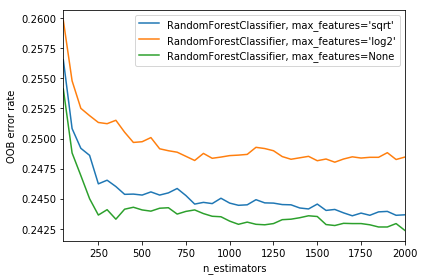

In [6]:
_oob_errors_max_features()

Train model with 5-fold cv. Output train and test multi-logloss as a measure of performance.

In [7]:
from sklearn.metrics import log_loss
def run_model(dtrain, dtest=None):
    params = {'max_features': 'sqrt',
              'criterion': 'entropy',
              'max_depth': None,
              'n_estimators': 2000,
              'oob_score': True,
              'n_jobs': -1,
              'random_state': 3668
              }
    clf = RandomForestClassifier()
    clf.set_params(**params)
    if dtest:
        clf.fit(dtrain[0], dtrain[1])
        y_train_pred, y_test_pred = clf.predict_proba(dtrain[0]), clf.predict_proba(dtest[0])
        y_train_loss, y_test_loss = log_loss(dtrain[1], y_train_pred), log_loss(dtest[1], y_test_pred)
        return clf, y_train_loss, y_test_loss
    else:
        clf.fit(dtrain[0], dtrain[1])
        y_train_pred = clf.predict_proba(dtrain[0])
        y_train_loss = log_loss(dtrain[1], y_train_pred)
        return clf, y_train_loss

In [8]:
def train_cv():
    X_train, y_train_cls, X_test, _, _ = load_data()
    X_train, X_test = _preprocess(X_train, X_test)

    cv_scores, n_folds = [], 5
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=816)
    for i, (train_ind, val_ind) in enumerate(skf.split(X_train, y_train_cls)):
        print("Running Fold", i + 1, "/", n_folds, end='\t')
        train_x, val_x = X_train.iloc[train_ind, :], X_train.iloc[val_ind, :]
        train_y, val_y = y_train_cls.iloc[train_ind], y_train_cls.iloc[val_ind]
        clf, train_loss, val_loss = run_model((train_x, train_y), (val_x, val_y))
        cv_scores.append([train_loss, val_loss])
        print("train_loss: {0:.6f}, val_loss: {1:.6f}".format(train_loss, val_loss))
    mean_train_loss = np.mean([cv_scores[i][0] for i in range(len(cv_scores))])
    mean_val_loss = np.mean([cv_scores[i][1] for i in range(len(cv_scores))])
    print("train_loss mean: {0:.6f}, val_loss mean: {1:.6f}".format(mean_train_loss, mean_val_loss))

In [9]:
train_cv()

Loading features files
Ordinal encoding
Features document-term matrix
Running Fold 1 / 5	train_loss: 0.138898, val_loss: 0.555241
Running Fold 2 / 5	train_loss: 0.139731, val_loss: 0.545222
Running Fold 3 / 5	train_loss: 0.139686, val_loss: 0.547898
Running Fold 4 / 5	train_loss: 0.139272, val_loss: 0.551318
Running Fold 5 / 5	train_loss: 0.139477, val_loss: 0.551304
train_loss mean: 0.139413, val_loss mean: 0.550197


Plot feature importance.

In [10]:
def _feature_importance(feat_names, importance):
    feat_importances = pd.DataFrame({'feature': feat_names, 'importance': importance})
    feat_importances = feat_importances.sort_values(by='importance', ascending=False)
    print(feat_importances)

    plt.style.use('ggplot')
    plt.figure()
    feat_importances = feat_importances.sort_values(by='importance', ascending=True)
    feat_importances.plot(kind='barh', x='feature', y='importance', legend=False, figsize=(10, 50))
    plt.title('Ramdom Forest Feature Importance')
    plt.xlabel('relative importance')
    plt.tight_layout()
    plt.show()

Loading features files
Ordinal encoding
Features document-term matrix
OOB error: 0.244
                                  feature  importance
30                            jwd_type_rt    0.041908
90           price_manager_id_mean_pred_1    0.037293
89           price_manager_id_mean_pred_0    0.035517
91           price_manager_id_mean_pred_2    0.034859
27                             time_stamp    0.032335
22                                  price    0.028733
6                             building_id    0.026878
28                  jwd_type_low_than_num    0.025966
25                          price_room_rt    0.024742
23                          price_bath_rt    0.023678
24                           price_bed_rt    0.022537
18                             listing_id    0.019951
13                        display_address    0.017421
31                      building_zero_num    0.017050
87                      manager_id_medium    0.016999
12                         desc_wordcount    0.01

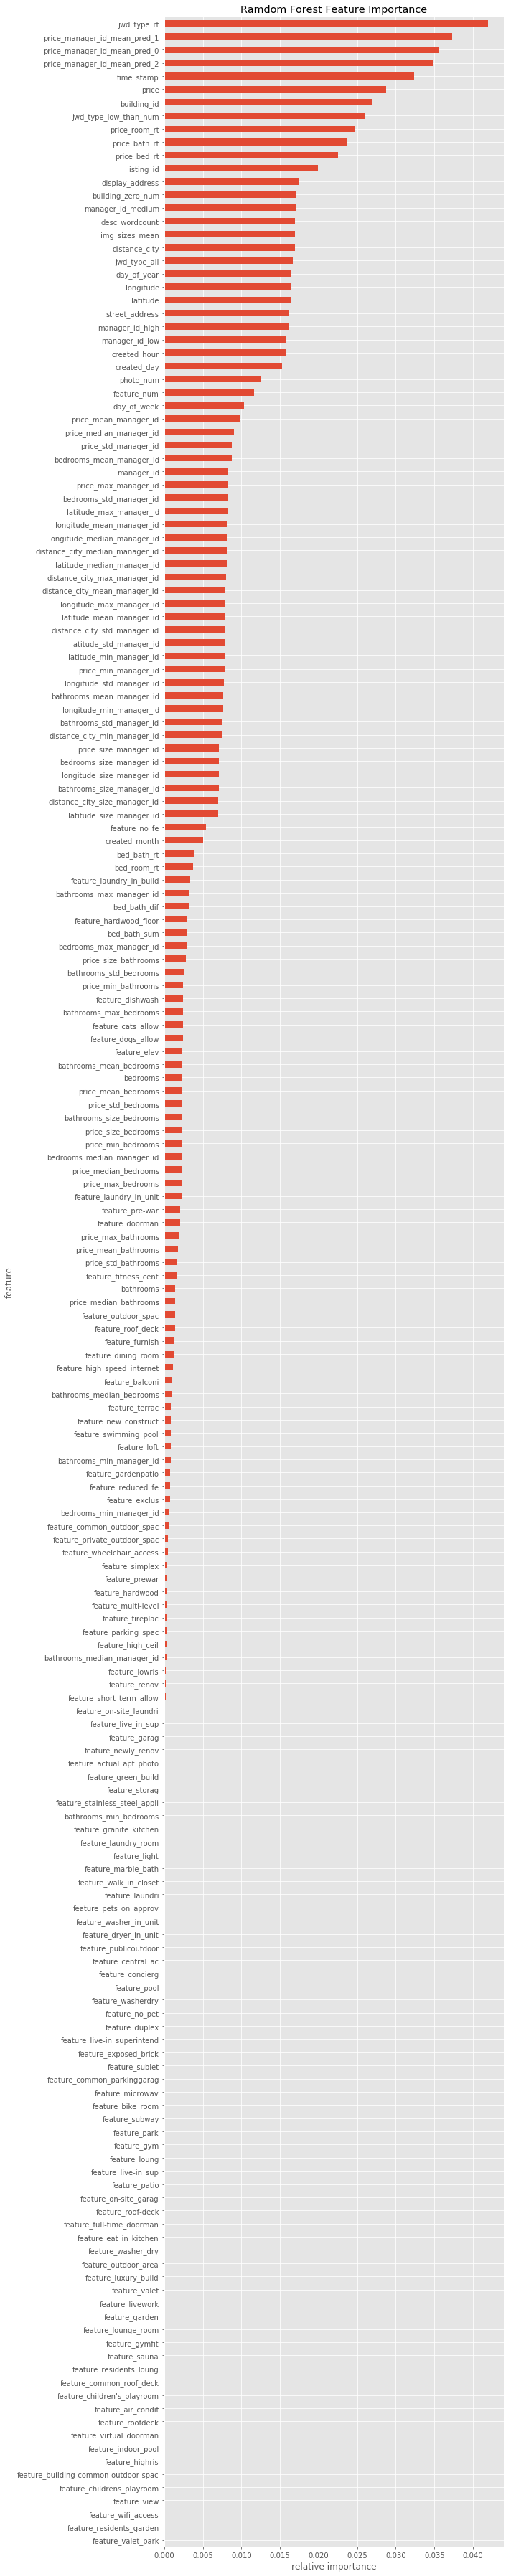

In [11]:
X_train, y_train_cls, X_test, feat_names, listing_id = load_data()
X_train, X_test = _preprocess_log(X_train, X_test)

params = {'max_features': 'sqrt',
          'criterion': 'entropy',
          'max_depth': None,
          'n_estimators': 2000,
          'oob_score': True,
          'n_jobs': -1,
          'random_state': 816
         }
clf = RandomForestClassifier()
clf.set_params(**params)
clf.fit(X_train, y_train_cls)
print('OOB error: {0:.3f}'.format(1-clf.oob_score_))

# feature importance
_feature_importance(feat_names, clf.feature_importances_)

The oob error plot indicates that without random feature subset, we get the highest prediction accuracy. The example shown above is still using sqrt subset of features in each split.